In [1]:
from air_hockey_challenge.framework.air_hockey_challenge_wrapper import AirHockeyChallengeWrapper
from air_hockey_challenge.framework.challenge_core import ChallengeCore
from air_hockey_challenge.framework.agent_base import AgentBase
from examples.control.hitting_agent_wait import build_agent as build_agent_hitting_wait
from air_hockey_challenge.framework.evaluate_agent import generate_init_states

from mushroom_rl.utils.dataset import parse_dataset, select_random_samples
from mushroom_rl.policy import GaussianTorchPolicy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim



from tqdm import tqdm

import pickle

import numpy as np

use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(f"Cuda: {use_cuda}")

Cuda: True


In [10]:
class Network(nn.Module):
    def __init__(self, input_shape, output_shape, n_features, **kwargs):
        super(Network, self).__init__()

        self._h1 = nn.Linear(input_shape[0], n_features)
        self._h2 = nn.Linear(n_features, n_features)
        self._h3 = nn.Linear(n_features, output_shape[0])

        nn.init.xavier_uniform_(self._h1.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h2.weight,
                                gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self._h3.weight,
                                gain=nn.init.calculate_gain('linear'))

    def forward(self, obs, **kwargs):
        features1 = torch.tanh(self._h1(torch.squeeze(obs, 1).float()))
        features2 = torch.tanh(self._h2(features1))
        return self._h3(features2)

class BCDataset(Dataset):
    def __init__(self, paths):
        states_list = []
        actions_list = []
        for path in paths:
            dataset = np.load(path, allow_pickle=True)
            print(dataset.shape)
            states, actions, rewards, next_states, absorbing, last  = parse_dataset(dataset)
            states_list.append(states)
            actions_list.append(actions.reshape(-1,6))
        self.states = torch.from_numpy(np.vstack(states_list)).to(device)
        self.expert_actions = torch.from_numpy(np.vstack(actions_list)).to(device)

    def __len__(self):
        
        return len(self.states)

    def __getitem__(self, index):
        return self.states[index], self.expert_actions[index]
    
class BCAgent(AgentBase):
    def __init__(self, env_info, policy, **kwargs):
        super().__init__(env_info, **kwargs)
        self.policy = policy

    def reset(self):
        pass

    def draw_action(self, observation):
        return self.policy.draw_action(observation).reshape(2,3)
    
def generate_init_joint_states(mdp ,env: str = "3dof-hit"):

    # create initial state
    obs = generate_init_states(env=env, n_episodes=1, n_parallel_cores=1)
    obs = obs[0].flatten()

    # get joint position limits
    # min_pos_limits = mdp.env_info['robot']['joint_pos_limit'][0, :]
    # max_pos_limits = mdp.env_info['robot']['joint_pos_limit'][1, :]
    min_pos_limits = obs[mdp.env_info['joint_pos_ids']] - 0.1*np.pi
    max_pos_limits = obs[mdp.env_info['joint_pos_ids']] + 0.1*np.pi

    # generate random joint positions
    random_joint_pos = np.random.uniform(low=min_pos_limits, high=max_pos_limits, size=(3,))

    # save random joint positions in the initial state
    obs[mdp.env_info['joint_pos_ids']] = random_joint_pos

    obs = obs.reshape((1,-1))

    return obs

def train_bc(policy, train_dataset, test_dataset, save_path, n_epochs, batch_size, lr=0.001):
    optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    epoch_pbar = tqdm(range(n_epochs), desc='Epoch')
    logs = dict(train_loss=[], test_loss=[])

    with torch.no_grad():
        test_loss = []
        for states, actions in test_dataloader:
            loss = -policy.log_prob_t(states, actions).mean()
            test_loss.append(loss.item())
        train_loss = []
        for states, actions in train_dataloader:
            
            loss = -policy.log_prob_t(states, actions).mean()
            train_loss.append(loss.item())
        avg_train_loss = np.mean(train_loss)
        avg_test_loss = np.mean(test_loss)
        epoch_pbar.set_postfix({'train loss': avg_train_loss, 'test loss': avg_test_loss})
        logs['train_loss'].append(avg_train_loss)
        logs['test_loss'].append(avg_test_loss)
        

    best_test_loss = np.inf

    for epoch in epoch_pbar:

        train_loss = []
        for states, actions in train_dataloader:
            optimizer.zero_grad()
            loss = -policy.log_prob_t(states, actions).mean()
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        with torch.no_grad():
            test_loss = []
            for states, actions in test_dataloader:
                loss = -policy.log_prob_t(states, actions).mean()
                test_loss.append(loss.item())

        avg_train_loss = np.mean(train_loss)
        avg_test_loss = np.mean(test_loss)
        epoch_pbar.set_postfix({'train loss': avg_train_loss, 'test loss': avg_test_loss})
        logs['train_loss'].append(avg_train_loss)
        logs['test_loss'].append(avg_test_loss)

        if avg_test_loss < best_test_loss:
            policy.save(save_path+"_best")
    policy.save(save_path+"_final")
    return logs

In [4]:
env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = build_agent_hitting_wait(mdp.env_info)
core = ChallengeCore(agent, mdp)

n_expert_traj = 5000
dataset_path = 'dataset/hit_rand_5000_2.pkl'

dataset = []
success_traj = 0
for i in tqdm(range(n_expert_traj)):
    while True:
        initial_state = generate_init_joint_states(mdp, env=env)
        new_traj = core.evaluate(initial_states=initial_state)
        # new_traj = core.evaluate(n_episodes=1)
        _, _, _, _, absorbed, _ = parse_dataset(new_traj)
        if absorbed[-1]: # we do not want examples where the "expert" did not score
            # print(success_traj)
            dataset += new_traj
            success_traj += 1
            break

print(f"Dataset size: {len(dataset)} from {success_traj} trajectories")

with open(dataset_path, 'wb') as f:
    pickle.dump(dataset, f)

100%|██████████| 5000/5000 [4:46:26<00:00,  3.44s/it]  


Dataset size: 608342 from 5000 trajectories


In [6]:
from air_hockey_challenge.utils.replay_dataset import replay_dataset

env = "3dof-hit"
dataset_path = 'dataset/hit_rand_5.pkl'

replay_dataset(env, dataset_path)

In [3]:
policy = GaussianTorchPolicy(Network, (12,), (6,), std_0=0.01, n_features=64, use_cuda=use_cuda)

In [11]:
train_dataset = BCDataset(["dataset/hit_rand_5000.pkl", "dataset/hit_rand_5000_2.pkl"])
test_dataset = BCDataset(["dataset/hit_rand_100.pkl"])

print(len(train_dataset))

AttributeError: 'list' object has no attribute 'shape'

: 

In [14]:
train_dataset = BCDataset(["dataset/hit_rand_5000.pkl", "dataset/hit_rand_5000_2.pkl"])
test_dataset = BCDataset(["dataset/hit_rand_100.pkl"])

logs = train_bc(policy, train_dataset=train_dataset, test_dataset=test_dataset, save_path="dataset/BC_10000",n_epochs=20, batch_size=32)

Epoch: 100%|██████████| 20/20 [1:23:10<00:00, 249.50s/it, train loss=-22.7, test loss=-25.8]


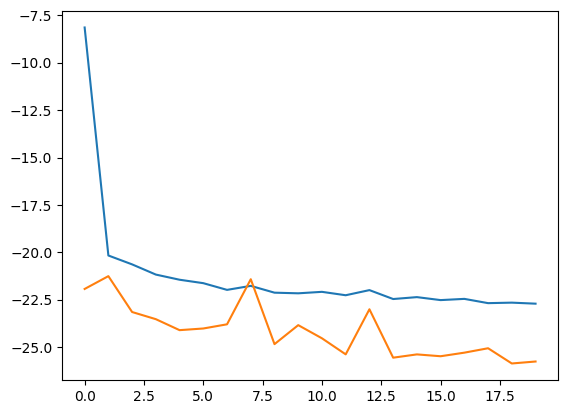

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.array(logs['train_loss'])[1:])
plt.plot(np.array(logs['test_loss'])[1:])

In [4]:
policy.load('logs/bc_ppo/bc/policy.pkl')

env = "3dof-hit"

mdp = AirHockeyChallengeWrapper(env)
mdp.reset()

agent = BCAgent(mdp.env_info, policy)
core = ChallengeCore(agent, mdp)

In [ ]:
eval = core.evaluate(n_episodes=5, render=True)

In [9]:
from air_hockey_challenge.framework.evaluate_agent import evaluate


def build_agent(env_info, **kwargs):
    return BCAgent(mdp.env_info, policy)

Before any training

In [11]:
eval = evaluate(build_agent, 'logs/bc_ppo/before', env_list=[env], n_episodes=50, render=False, quiet=False, n_cores=1)
policy.save('logs/bc_ppo/before/policy.pkl')

Environment:        3dof-hit
Number of Episodes: 50
Success:            0.0000
Penalty:            230.5
Number of Violations: 
  joint_pos_constr  5
  joint_vel_constr  50
  ee_constr         40
  Jerk              50
  Computation Time  1
  Total             146
-------------------------------------------------



After BC

In [17]:
eval = evaluate(build_agent, 'logs/bc_ppo/bc', env_list=[env], n_episodes=50, render=False, quiet=False, n_cores=1)
policy.save('logs/bc_ppo/bc/policy.pkl')

Environment:        3dof-hit
Number of Episodes: 50
Success:            0.0400
Penalty:            205
Number of Violations: 
  joint_pos_constr  14
  joint_vel_constr  50
  ee_constr         25
  Jerk              50
  Computation Time  1
  Total             140
-------------------------------------------------

